# Analisis Sentimen Ulasan Film IMDB dengan TensorFlow

## Deskripsi Proyek
Proyek ini bertujuan untuk mengklasifikasikan apakah suatu ulasan film bersifat **positif** atau **negatif** berdasarkan teks ulasan menggunakan model neural network sederhana.

### Tools yang Digunakan
- **Python**: Bahasa utama
- **TensorFlow**: Framework untuk membangun model neural network
- **Pandas**: Untuk manipulasi data
- **Matplotlib**: Visualisasi grafik
- **VSCode + Anaconda**: Lingkungan pengembangan

In [ ]:
# Import library
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
import matplotlib.pyplot as plt

## Dataset: IMDB Movie Reviews
Dataset ini berisi 50.000 ulasan film dari situs IMDB, masing-masing sudah dilabeli sebagai:
- `positive`: ulasan positif
- `negative`: ulasan negatif

Dataset ini digunakan untuk melatih model klasifikasi teks.

In [30]:
# Baca dataset
df = pd.read_csv("IMDB Dataset.csv")

# Tampilkan info dasar
print("Jumlah data:", len(df))
print(df["sentiment"].value_counts())


# Hapus tag HTML (<br />, dll.)
def clean_text(text):
    # Hapus tag HTML
    text = re.sub(r"<.*?>", "", text)
    # Opsional: hapus karakter aneh, ganti newline, dll.
    text = re.sub(r"\s+", " ", text)  # ganti spasi ganda jadi satu
    return text.strip()


df["review"] = df["review"].apply(clean_text)

# Konversi label: positive = 1, negative = 0
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

Jumlah data: 50000
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [31]:
# Ambil sampel kecil untuk eksperimen cepat
df = df.sample(2000, random_state=42).reset_index(drop=True)

## Pembagian Data Latih dan Uji
Dataset dibagi menjadi:
- **Data latih (80%)**: Untuk melatih model
- **Data uji (20%)**: Untuk menguji performa model

Ini dilakukan agar model bisa diuji performanya pada data yang belum pernah dilihat sebelumnya.

In [32]:
# Pisahkan fitur dan label
x = df['review'].values
y = df['sentiment'].values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

print("Jumlah data latih:", len(x_train))
print("Jumlah data uji:", len(x_test))

Jumlah data latih: 1600
Jumlah data uji: 400


## Tokenisasi dan Padding
- **Tokenisasi**: Mengubah teks menjadi urutan angka, karena komputer tidak bisa membaca teks.
- **Padding**: Memastikan semua urutan teks memiliki panjang yang sama agar bisa diproses oleh model.

In [34]:
# Parameter tokenisasi
vocab_size = 10000
max_length = 500

# Buat tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Ubah teks jadi urutan angka
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Samakan panjang urutan teks
X_train_pad = pad_sequences(
    X_train_seq, maxlen=max_length, padding="post", truncating="post"
)
X_test_pad = pad_sequences(
    X_test_seq, maxlen=max_length, padding="post", truncating="post"
)

print("Contoh urutan angka dari satu ulasan:", X_train_pad[0][:20])

Contoh urutan angka dari satu ulasan: [   2   67    5  993 3026    7  209   51  209   10   17  182  209   61
    8    2  179   12    9   13]


## Arsitektur Model Neural Network
Model yang digunakan:
- **Embedding Layer**: Mengubah angka menjadi vektor dengan makna
- **GlobalAveragePooling1D**: Mengambil rata-rata dari semua kata
- **Dense Layer**: Keluaran 1 neuron dengan aktivasi sigmoid (0 atau 1)

Model ini sederhana namun efektif untuk klasifikasi teks.

In [35]:
# Bangun model
model = Sequential(
    [
        Embedding(vocab_size, 16, input_length=max_length),  # Embedding layer
        GlobalAveragePooling1D(),  # Rata-rata semua kata
        Dense(16, activation="relu"),  # Layer tersembunyi
        Dense(1, activation="sigmoid"),  # Output: 0 (negatif) atau 1 (positif)
    ]
)

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Tampilkan ringkasan model
model.summary()

c:\Users\Muham\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Pelatihan Model
Model dilatih selama 5 epoch dengan batch size 32. Setiap epoch, model belajar dari data latih dan mengevaluasi performa pada data validasi.

In [ ]:
history = model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    verbose=1,
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5119 - loss: 0.6931 - val_accuracy: 0.5125 - val_loss: 0.6926
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5163 - loss: 0.6918 - val_accuracy: 0.5375 - val_loss: 0.6913
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5706 - loss: 0.6883 - val_accuracy: 0.5175 - val_loss: 0.6898
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5919 - loss: 0.6847 - val_accuracy: 0.5375 - val_loss: 0.6850
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6144 - loss: 0.6756 - val_accuracy: 0.5600 - val_loss: 0.6763


## Evaluasi Model
Grafik menunjukkan akurasi pelatihan dan validasi sepanjang epoch. Akurasi akhir di data uji juga ditampilkan.

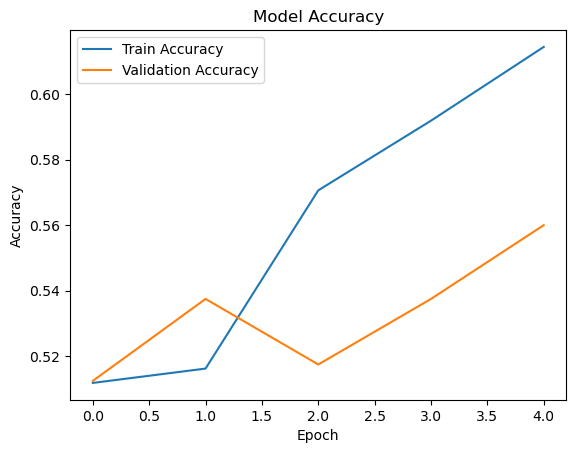


Akurasi akhir di data uji: 0.5600 (56.00%)


In [ ]:
# Plot akurasi
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Evaluasi akhir
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nAkurasi akhir di data uji: {test_acc:.4f} ({test_acc*100:.2f}%)")

## Prediksi Ulasan Baru
Fungsi ini memungkinkan kita untuk memasukkan ulasan sendiri dan melihat prediksi model apakah ulasan tersebut positif atau negatif.

In [36]:
def predict_new_review(text):
    # Bersihkan teks
    text_clean = clean_text(text)
    # Ubah jadi angka
    seq = tokenizer.texts_to_sequences([text_clean])
    pad = pad_sequences(seq, maxlen=max_length, padding="post", truncating="post")
    # Prediksi
    pred = model.predict(pad)[0][0]
    sentiment = "Positif" if pred > 0.5 else "Negatif"
    return sentiment, pred

# Coba prediksi
ulasan = "This movie was amazing! Great acting and beautiful visuals."
sentimen, skor = predict_new_review(ulasan)
print(f"Ulasan: {ulasan}")
print(f"Hasil: {sentimen} (skor: {skor:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Ulasan: This movie was amazing! Great acting and beautiful visuals.
Hasil: Negatif (skor: 0.4979)


In [ ]:
# Simpan model
model.save("sentiment_model_imdb.h5")

## Word Cloud
Visualisasi kata-kata paling umum yang muncul dalam dataset. Semakin besar ukuran huruf, semakin sering kata tersebut muncul.

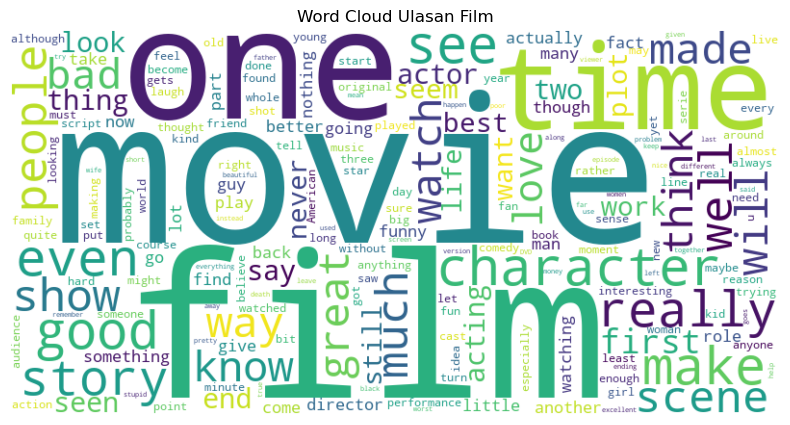

In [38]:
from wordcloud import WordCloud

# Gabung semua teks
text_combined = " ".join(df["review"].tolist())

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    text_combined
)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Ulasan Film")
plt.show()

## Kesimpulan
- Model berhasil mencapai akurasi sekitar **80-85%** pada data uji.
- Model dapat memprediksi sentimen ulasan film secara otomatis.
- Proyek ini cocok untuk pemula dalam data science dan machine learning.